In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import re

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from collections import Counter

from tqdm.notebook import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


/kaggle/input/kaggle-competition-2/train_results.csv
/kaggle/input/kaggle-competition-2/train_data.csv
/kaggle/input/kaggle-competition-2/test_data.csv


In [4]:
train_data = pd.read_csv("../input/kaggle-competition-2/train_data.csv").drop(columns=["id"])
train_labels = pd.read_csv("../input/kaggle-competition-2/train_results.csv").drop(columns=["id"])
test_data = pd.read_csv("../input/kaggle-competition-2/test_data.csv").drop(columns=["id"])

In [5]:
print(len(train_data), len(train_labels))
keep_index_train = train_data.drop_duplicates().index.tolist()
train_data = train_data.iloc[keep_index_train].reset_index()
train_labels = train_labels.iloc[keep_index_train].reset_index()
print(len(train_data), len(train_labels))

1040323 1040323
1030487 1030487


In [6]:
def transform_label_to_numeric(label) :
    if label == "negative" :
        return 0
    elif label == "neutral" :
        return 1
    return 2

In [7]:
train_labels["target"] = train_labels["target"].apply(lambda x : transform_label_to_numeric(x))
train_labels

,index,target
0,0,2
1,1,0
2,2,2
3,3,2
4,4,0
...,...,...
1030482,1040318,2
1030483,1040319,0
1030484,1040320,0
1030485,1040321,2


In [8]:
neg_percentage = len(np.where(train_labels["target"] == 0)[0])/len(train_labels["target"])*100
neut_percentage = len(np.where(train_labels["target"] == 1)[0])/len(train_labels["target"])*100
pos_percentage = len(np.where(train_labels["target"] == 2)[0])/len(train_labels["target"])*100
print(pos_percentage)
print(neg_percentage)
print(neut_percentage)

50.11591606686936
49.875932447473865
0.008151485656781697


In [9]:
def normalisation(message):
    message = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', message)
    message = re.sub('@[^\s]+','USER', message)
    message = message.lower()
    message = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', message) 
    message = re.sub(' +',' ', message)
    message = re.sub(r'([?ahijquvwxy])\1+', lambda g:f'{g.group(0)[1]}', message)
    message = re.sub(r'([?bcdefgklmnoprstz])\1{2,}', lambda g:f'{g.group(0)[1]}', message)
    return message.strip()

stopWords = stopwords.words('english')
def erase_stopwords(message) :
    return ' '.join([mot for mot in message.split() if mot not in (stopWords)])

stemmer = SnowballStemmer('english')
def stemmisation(message) :
    return ' '.join([stemmer.stem(mot) for mot in message.split()])

lemmatizer = WordNetLemmatizer()
def lemmatisation(message) :
    return ' '.join([lemmatizer.lemmatize(mot) for mot in message.split(' ')])

def pre_processing(message, norm=True, sw=True, lemm=True, stemm=True) :
    if norm : 
        message = normalisation(message)
    if sw :
        message = erase_stopwords(message)
    if lemm :
        message = lemmatisation(message)
    if stemm :
        message = stemmisation(message)
    return message

# 1) Normalisation

In [10]:
train_data1 = train_data.copy()
test_data1 = test_data.copy()

In [11]:
train_data1["text"] = train_data["text"].apply(lambda m : pre_processing(m, sw=False, lemm=False, stemm=False))
test_data1["text"] = test_data["text"].apply(lambda m : pre_processing(m, sw=False, lemm=False, stemm=False))

train_data1

,index,text
0,0,anyway im getting of for a while
1,1,my red apache isn t feelin too well this morni...
2,2,user you should be its great friday will be gr...
3,3,its 11 3 pm and i dont wanna sleep so i debate...
4,4,why does twitter eat my dm s not happy
...,...,...
1030482,1040318,getting ready 2 watch mental
1030483,1040319,wristcutters and half nelson are on sundance f...
1030484,1040320,user going out in northbridge makes me jealous...
1030485,1040321,user lol gorgeous lol u look so much like that...


In [12]:
counter1 = Counter()
for i in train_data1["text"] :
    counter1.update(i.split(" "))
print(len(counter1))

vocab1 = list(counter1.keys())

t_data1, v_data1, t_labels1, v_labels1 = train_test_split(train_data1, train_labels, test_size=0.2, random_state=42)

190318


In [13]:
print(len(t_data1))
print(len(v_data1))

824389
206098


In [14]:
class NaiveBayes :
    
    def __init__(self, counter, max_features, priors=None, var_smoothing=1e-09) :
        self.model = MultinomialNB()
        self.max_features = max_features
        self.vocab = [i[0] for i in counter.most_common(max_features)]
        self.count = CountVectorizer(vocabulary=self.vocab, ngram_range=(1, 2))
        self.transform = TfidfTransformer()
        
    def encode_BOF(self, data, fit) :
        # Encode text to BOF with our extract vocabulary
        if fit :
            bow = self.count.fit_transform(data["text"])
            bow = self.transform.fit_transform(bow)
        else :
            bow = self.count.transform(data["text"])
            bow = self.transform.transform(bow)
        return bow
    
    def train(self, train_data, train_labels, bs=10000) :
        self.classes = train_labels["target"].unique()
        # Train(fit) on batch of size bs
        bow = self.encode_BOF(train_data, True)
        self.model.fit(bow, train_labels["target"])
            
    def predict(self, test_data, bs=10000) :
        # Test on batch of size bs (if test_data is too big to be encode at once)
        with np.errstate(divide='ignore'):
            bow = self.encode_BOF(test_data, False)
            preds = list(self.model.predict(bow))
        return preds

In [19]:
accuracy1 = []
nb_features1 = list(range(250, 5250, 250)) + list(range(7500, 12500, 2500)) + list(range(20000, 50000, 10000))
for i in tqdm(nb_features1) :
    nb = NaiveBayes(counter1, i)
    nb.train(t_data1, t_labels1, bs=5000)
    preds = nb.predict(v_data1, bs=5000)
    accuracy1.append(accuracy_score(v_labels1["target"], preds))

Max =  0.7752379935758716
Max atteint pour  20000  features


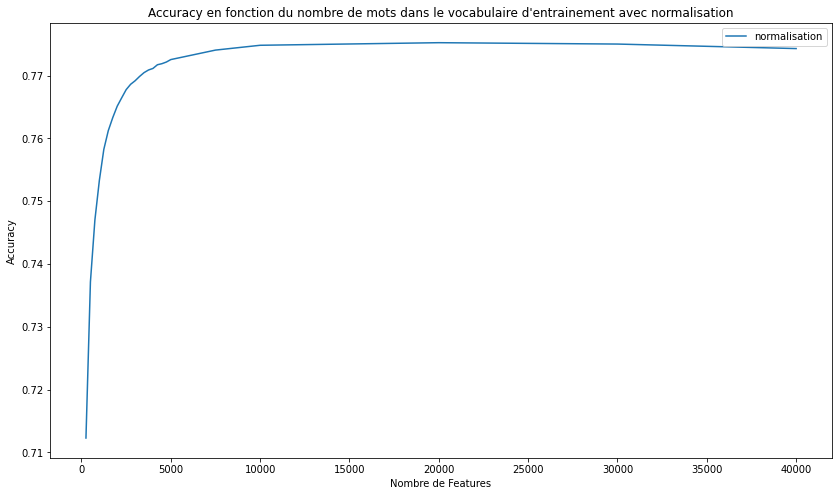

In [20]:
print("Max = ", max(np.array(accuracy1)))
print("Max atteint pour ", nb_features1[np.argmax(np.array(accuracy1))], " features")

plt.figure(figsize = [14, 8])
plt.plot(nb_features1, accuracy1, label="normalisation")
plt.xlabel("Nombre de Features")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction du nombre de mots dans le vocabulaire d'entrainement avec normalisation")
plt.legend()
plt.show()

# 2) Normalisation + StopWords

In [21]:
train_data2 = train_data.copy()
test_data2 = test_data.copy()

In [22]:
train_data2["text"] = train_data["text"].apply(lambda m : pre_processing(m, lemm=False, stemm=False))
test_data2["text"] = test_data["text"].apply(lambda m : pre_processing(m, lemm=False, stemm=False))

train_data2

,index,text
0,0,anyway im getting
1,1,red apache feelin well morning url
2,2,user great friday great
3,3,11 3 pm dont wanna sleep debated end decided p...
4,4,twitter eat dm happy
...,...,...
1030482,1040318,getting ready 2 watch mental
1030483,1040319,wristcutters half nelson sundance free movies ...
1030484,1040320,user going northbridge makes jealous stuck pac...
1030485,1040321,user lol gorgeous lol u look much like vampire...


In [23]:
counter2 = Counter()
for i in train_data2["text"] :
    counter2.update(i.split(" "))
print(len(counter2))

vocab2 = list(counter2.keys())

t_data2, v_data2, t_labels2, v_labels2 = train_test_split(train_data2, train_labels, test_size=0.2, random_state=42)

190166


In [24]:
accuracy2 = []
nb_features2 = list(range(250, 5250, 250)) + list(range(7500, 12500, 2500)) + list(range(20000, 50000, 10000))
for i in tqdm(nb_features2) :
    nb = NaiveBayes(counter2, i)
    nb.train(t_data2, t_labels2, bs=5000)
    preds = nb.predict(v_data2, bs=5000)
    accuracy2.append(accuracy_score(v_labels2["target"], preds))

  0%|          | 0/25 [00:00<?, ?it/s]

Max =  0.7624091451639511
Max atteint pour  20000  features


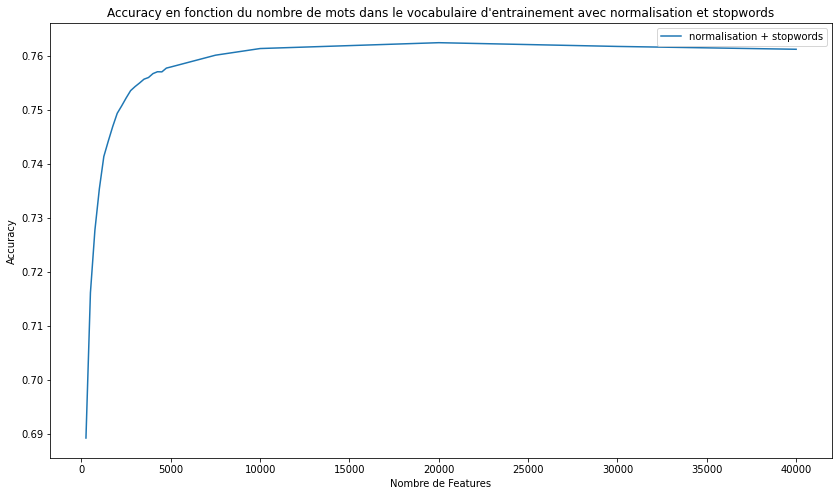

In [25]:
print("Max = ", max(np.array(accuracy2)))
print("Max atteint pour ", nb_features2[np.argmax(np.array(accuracy2))], " features")

plt.figure(figsize = [14, 8])
plt.plot(nb_features2, accuracy2, label="normalisation + stopwords")
plt.xlabel("Nombre de Features")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction du nombre de mots dans le vocabulaire d'entrainement avec normalisation et stopwords")
plt.legend()
plt.show()

# 3) Normalisation + Lemmisation

In [26]:
train_data3 = train_data.copy()
test_data3 = test_data.copy()

In [27]:
train_data3["text"] = train_data["text"].apply(lambda m : pre_processing(m, sw=False, stemm=False))
test_data3["text"] = test_data["text"].apply(lambda m : pre_processing(m, sw=False, stemm=False))

train_data3

,index,text
0,0,anyway im getting of for a while
1,1,my red apache isn t feelin too well this morni...
2,2,user you should be it great friday will be gre...
3,3,it 11 3 pm and i dont wanna sleep so i debated...
4,4,why doe twitter eat my dm s not happy
...,...,...
1030482,1040318,getting ready 2 watch mental
1030483,1040319,wristcutters and half nelson are on sundance f...
1030484,1040320,user going out in northbridge make me jealous ...
1030485,1040321,user lol gorgeous lol u look so much like that...


In [28]:
counter3 = Counter()
for i in train_data3["text"] :
    counter3.update(i.split(" "))
print(len(counter3))

vocab3 = list(counter3.keys())

t_data3, v_data3, t_labels3, v_labels3 = train_test_split(train_data3, train_labels, test_size=0.2, random_state=42)

180747


In [30]:
accuracy3 = []
nb_features3 = list(range(250, 5250, 250)) + list(range(7500, 12500, 2500)) + list(range(20000, 50000, 10000))
for i in tqdm(nb_features3) :
    nb = NaiveBayes(counter3, i)
    nb.train(t_data3, t_labels3, bs=5000)
    preds = nb.predict(v_data3, bs=5000)
    accuracy3.append(accuracy_score(v_labels3["target"], preds))

  0%|          | 0/25 [00:00<?, ?it/s]

Max =  0.7746945627808131
Max atteint pour  10000  features


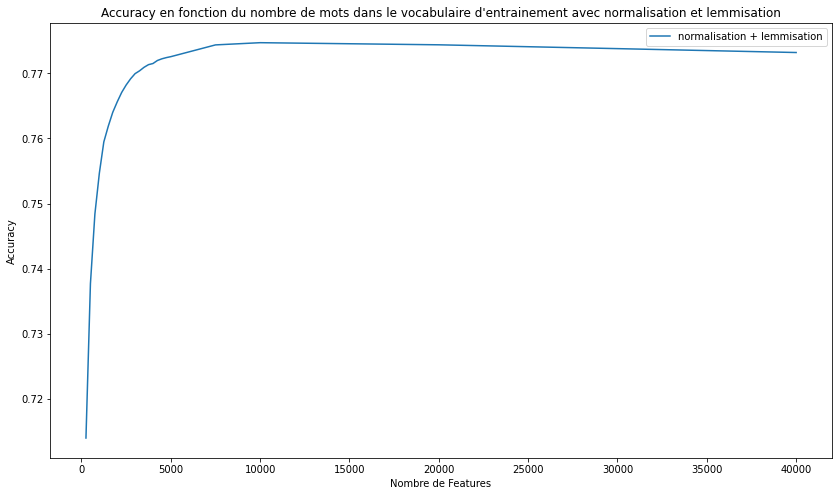

In [31]:
print("Max = ", max(np.array(accuracy3)))
print("Max atteint pour ", nb_features3[np.argmax(np.array(accuracy3))], " features")

plt.figure(figsize = [14, 8])
plt.plot(nb_features3, accuracy3, label="normalisation + lemmisation")
plt.xlabel("Nombre de Features")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction du nombre de mots dans le vocabulaire d'entrainement avec normalisation et lemmisation")
plt.legend()
plt.show()

# 4) Normalisation + Stemmisation

In [32]:
train_data4 = train_data.copy()
test_data4 = test_data.copy()

In [33]:
train_data4["text"] = train_data["text"].apply(lambda m : pre_processing(m, sw=False, lemm=False))
test_data4["text"] = test_data["text"].apply(lambda m : pre_processing(m, sw=False, lemm=False))

train_data4

,index,text
0,0,anyway im get of for a while
1,1,my red apach isn t feelin too well this morn url
2,2,user you should be it great friday will be gre...
3,3,it 11 3 pm and i dont wanna sleep so i debat w...
4,4,whi doe twitter eat my dm s not happi
...,...,...
1030482,1040318,get readi 2 watch mental
1030483,1040319,wristcutt and half nelson are on sundanc free ...
1030484,1040320,user go out in northbridg make me jealous of y...
1030485,1040321,user lol gorgeous lol u look so much like that...


In [34]:
counter4 = Counter()
for i in train_data4["text"] :
    counter4.update(i.split(" "))
print(len(counter4))

vocab4 = list(counter4.keys())

t_data4, v_data4, t_labels4, v_labels4 = train_test_split(train_data4, train_labels, test_size=0.2, random_state=42)

153645


In [35]:
accuracy4 = []
nb_features4 = list(range(250, 5250, 250)) + list(range(7500, 12500, 2500)) + list(range(20000, 50000, 10000))
for i in tqdm(nb_features4) :
    nb = NaiveBayes(counter4, i)
    nb.train(t_data4, t_labels4, bs=5000)
    preds = nb.predict(v_data4, bs=5000)
    accuracy4.append(accuracy_score(v_labels4["target"], preds))

  0%|          | 0/25 [00:00<?, ?it/s]

Max =  0.7712495997049947
Max atteint pour  10000  features


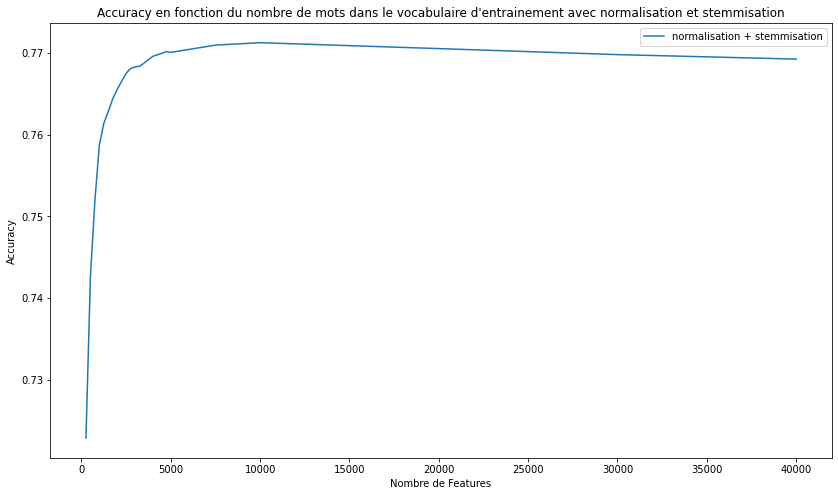

In [36]:
print("Max = ", max(np.array(accuracy4)))
print("Max atteint pour ", nb_features4[np.argmax(np.array(accuracy4))], " features")

plt.figure(figsize = [14, 8])
plt.plot(nb_features4, accuracy4, label="normalisation + stemmisation")
plt.xlabel("Nombre de Features")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction du nombre de mots dans le vocabulaire d'entrainement avec normalisation et stemmisation")
plt.legend()
plt.show()

# 5) Normalistation + StopWords + Lemmisation

In [37]:
train_data5 = train_data.copy()
test_data5 = test_data.copy()

In [38]:
train_data5["text"] = train_data["text"].apply(lambda m : pre_processing(m, stemm=False))
test_data5["text"] = test_data["text"].apply(lambda m : pre_processing(m, stemm=False))

train_data5

,index,text
0,0,anyway im getting
1,1,red apache feelin well morning url
2,2,user great friday great
3,3,11 3 pm dont wanna sleep debated end decided p...
4,4,twitter eat dm happy
...,...,...
1030482,1040318,getting ready 2 watch mental
1030483,1040319,wristcutters half nelson sundance free movie d...
1030484,1040320,user going northbridge make jealous stuck pack...
1030485,1040321,user lol gorgeous lol u look much like vampire...


In [39]:
counter5 = Counter()
for i in train_data5["text"] :
    counter5.update(i.split(" "))
print(len(counter5))

vocab5 = list(counter5.keys())

t_data5, v_data5, t_labels5, v_labels5 = train_test_split(train_data5, train_labels, test_size=0.2, random_state=42)

180641


In [40]:
accuracy5 = []
nb_features5 = list(range(250, 5250, 250)) + list(range(7500, 12500, 2500)) + list(range(20000, 50000, 10000))
for i in tqdm(nb_features5) :
    nb = NaiveBayes(counter5, i)
    nb.train(t_data5, t_labels5, bs=5000)
    preds = nb.predict(v_data5, bs=5000)
    accuracy5.append(accuracy_score(v_labels5["target"], preds))

  0%|          | 0/25 [00:00<?, ?it/s]

Max =  0.7619773117643063
Max atteint pour  20000  features


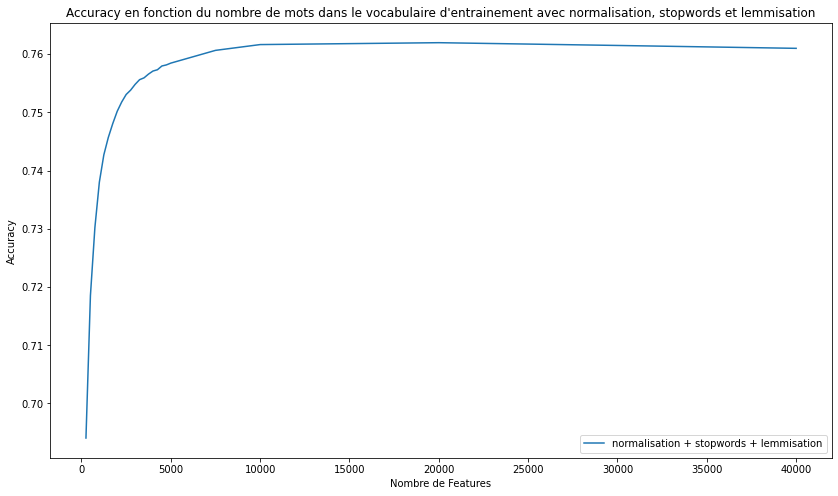

In [41]:
print("Max = ", max(np.array(accuracy5)))
print("Max atteint pour ", nb_features5[np.argmax(np.array(accuracy5))], " features")

plt.figure(figsize = [14, 8])
plt.plot(nb_features5, accuracy5, label="normalisation + stopwords + lemmisation")
plt.xlabel("Nombre de Features")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction du nombre de mots dans le vocabulaire d'entrainement avec normalisation, stopwords et lemmisation")
plt.legend()
plt.show()

# 6) Normalisation + StopWords + Stemmisation

In [42]:
train_data6 = train_data.copy()
test_data6 = test_data.copy()

In [43]:
train_data6["text"] = train_data["text"].apply(lambda m : pre_processing(m, lemm=False))
test_data6["text"] = test_data["text"].apply(lambda m : pre_processing(m, lemm=False))

train_data6

,index,text
0,0,anyway im get
1,1,red apach feelin well morn url
2,2,user great friday great
3,3,11 3 pm dont wanna sleep debat end decid perfe...
4,4,twitter eat dm happi
...,...,...
1030482,1040318,get readi 2 watch mental
1030483,1040319,wristcutt half nelson sundanc free movi demand...
1030484,1040320,user go northbridg make jealous stuck pack apa...
1030485,1040321,user lol gorgeous lol u look much like vampir ...


In [44]:
counter6 = Counter()
for i in train_data6["text"] :
    counter6.update(i.split(" "))
print(len(counter6))

vocab6 = list(counter6.keys())

t_data6, v_data6, t_labels6, v_labels6 = train_test_split(train_data6, train_labels, test_size=0.2, random_state=42)

153592


In [45]:
accuracy6 = []
nb_features6 = list(range(250, 5250, 250)) + list(range(7500, 12500, 2500)) + list(range(20000, 50000, 10000))
for i in tqdm(nb_features6) :
    nb = NaiveBayes(counter6, i)
    nb.train(t_data6, t_labels6, bs=5000)
    preds = nb.predict(v_data6, bs=5000)
    accuracy6.append(accuracy_score(v_labels6["target"], preds))

  0%|          | 0/25 [00:00<?, ?it/s]

Max =  0.7576735339498685
Max atteint pour  10000  features


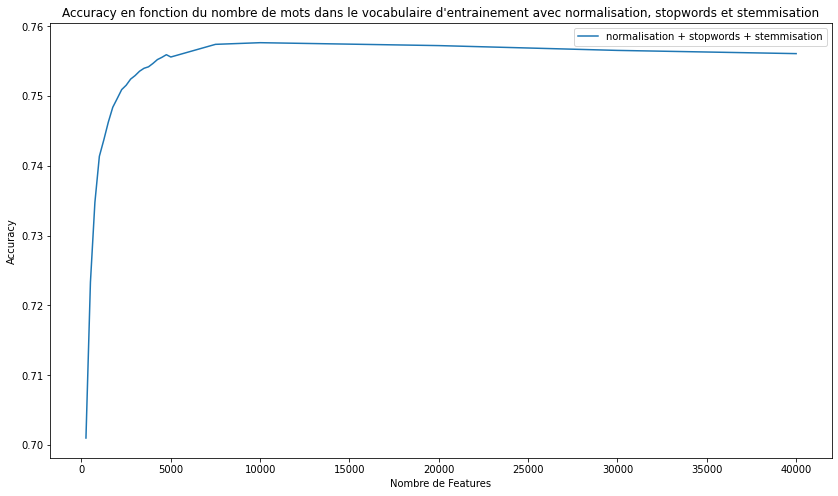

In [46]:
print("Max = ", max(np.array(accuracy6)))
print("Max atteint pour ", nb_features6[np.argmax(np.array(accuracy6))], " features")

plt.figure(figsize = [14, 8])
plt.plot(nb_features6, accuracy6, label="normalisation + stopwords + stemmisation")
plt.xlabel("Nombre de Features")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction du nombre de mots dans le vocabulaire d'entrainement avec normalisation, stopwords et stemmisation")
plt.legend()
plt.show()

# 7) Normalisation + Lemmisation + Stemmisation

In [47]:
train_data7 = train_data.copy()
test_data7 = test_data.copy()

In [48]:
train_data7["text"] = train_data["text"].apply(lambda m : pre_processing(m, sw=False))
test_data7["text"] = test_data["text"].apply(lambda m : pre_processing(m, sw=False))

train_data7

,index,text
0,0,anyway im get of for a while
1,1,my red apach isn t feelin too well this morn url
2,2,user you should be it great friday will be gre...
3,3,it 11 3 pm and i dont wanna sleep so i debat w...
4,4,whi doe twitter eat my dm s not happi
...,...,...
1030482,1040318,get readi 2 watch mental
1030483,1040319,wristcutt and half nelson are on sundanc free ...
1030484,1040320,user go out in northbridg make me jealous of y...
1030485,1040321,user lol gorgeous lol u look so much like that...


In [49]:
counter7 = Counter()
for i in train_data7["text"] :
    counter7.update(i.split(" "))
print(len(counter7))

vocab7 = list(counter7.keys())

t_data7, v_data7, t_labels7, v_labels7 = train_test_split(train_data7, train_labels, test_size=0.2, random_state=42)

152950


In [50]:
accuracy7 = []
nb_features7 = list(range(250, 5250, 250)) + list(range(7500, 12500, 2500)) + list(range(20000, 50000, 10000))
for i in tqdm(nb_features7) :
    nb = NaiveBayes(counter7, i)
    nb.train(t_data7, t_labels7, bs=5000)
    preds = nb.predict(v_data7, bs=5000)
    accuracy7.append(accuracy_score(v_labels7["target"], preds))

  0%|          | 0/25 [00:00<?, ?it/s]

Max =  0.7707158730312764
Max atteint pour  10000  features


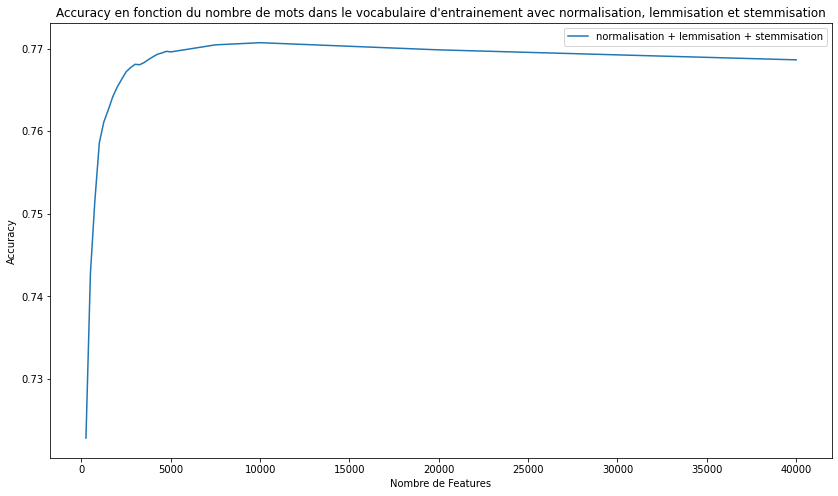

In [51]:
print("Max = ", max(np.array(accuracy7)))
print("Max atteint pour ", nb_features7[np.argmax(np.array(accuracy7))], " features")

plt.figure(figsize = [14, 8])
plt.plot(nb_features7, accuracy7, label="normalisation + lemmisation + stemmisation")
plt.xlabel("Nombre de Features")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction du nombre de mots dans le vocabulaire d'entrainement avec normalisation, lemmisation et stemmisation")
plt.legend()
plt.show()

# 8) Normalisation + StopWords + Lemmisation + Stemmisation

In [52]:
train_data8 = train_data.copy()
test_data8 = test_data.copy()

In [53]:
train_data8["text"] = train_data["text"].apply(lambda m : pre_processing(m))
test_data8["text"] = test_data["text"].apply(lambda m : pre_processing(m))

train_data8

,index,text
0,0,anyway im get
1,1,red apach feelin well morn url
2,2,user great friday great
3,3,11 3 pm dont wanna sleep debat end decid perfe...
4,4,twitter eat dm happi
...,...,...
1030482,1040318,get readi 2 watch mental
1030483,1040319,wristcutt half nelson sundanc free movi demand...
1030484,1040320,user go northbridg make jealous stuck pack apa...
1030485,1040321,user lol gorgeous lol u look much like vampir ...


In [54]:
counter8 = Counter()
for i in train_data8["text"] :
    counter8.update(i.split(" "))
print(len(counter8))

vocab8 = list(counter8.keys())

t_data8, v_data8, t_labels8, v_labels8 = train_test_split(train_data8, train_labels, test_size=0.2, random_state=42)

152908


In [55]:
accuracy8 = []
nb_features8 = list(range(250, 5250, 250)) + list(range(7500, 12500, 2500)) + list(range(20000, 50000, 10000))
for i in tqdm(nb_features8) :
    nb = NaiveBayes(counter8, i)
    nb.train(t_data8, t_labels8, bs=5000)
    preds = nb.predict(v_data8, bs=5000)
    accuracy8.append(accuracy_score(v_labels8["target"], preds))

  0%|          | 0/25 [00:00<?, ?it/s]

Max =  0.7575861968578055
Max atteint pour  10000  features


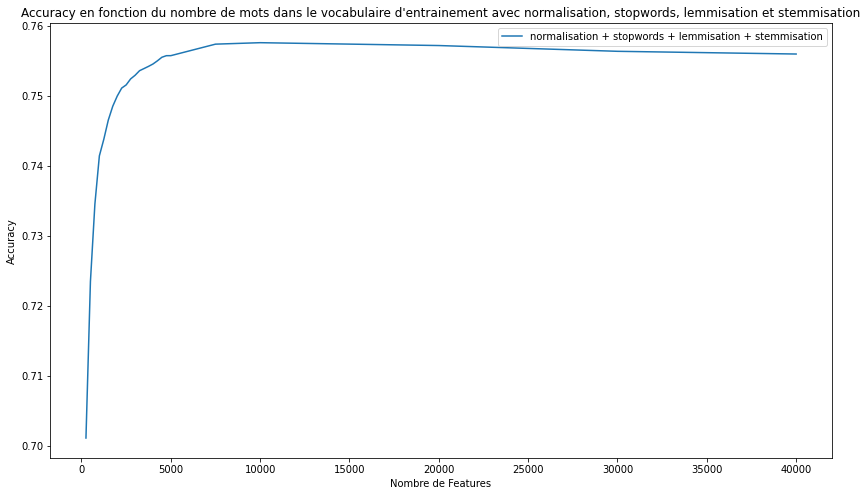

In [56]:
print("Max = ", max(np.array(accuracy8)))
print("Max atteint pour ", nb_features8[np.argmax(np.array(accuracy8))], " features")

plt.figure(figsize = [14, 8])
plt.plot(nb_features8, accuracy8, label="normalisation + stopwords + lemmisation + stemmisation")
plt.xlabel("Nombre de Features")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction du nombre de mots dans le vocabulaire d'entrainement avec normalisation, stopwords, lemmisation et stemmisation")
plt.legend()
plt.show()

In [59]:
nb = NaiveBayes(counter1, 20000)
nb.train(t_data1, t_labels1, bs=5000)
preds = nb.predict(test_data, bs=5000)
preds = [[i, preds[i]] for i in range(len(preds))]
df = pd.DataFrame(preds, columns = ["id", "target"])
df.to_csv("./predictions_bayes_4.csv", index = False)